<style>
    body {
        font-family: Times New Roman, sans-serif;
    }
</style>
# Computer Assignment 3: Pyramid Transforms
## Alaqian Zafar - aaz7118

In this assignment, you will implement 2D Gaussian, Laplacian pyramids and a Wavelet transform in Python, and look at their reconstruction qualities and representation efficiency.

You'll need to have python packages for `OpenCV`  and `PyWavelets` installed. Throughout the following problems, keep your input images on the `uint8` scale of [0,255].


## Table of Contents
- <a href='#p1'>**Problem 1** (Gaussian and Laplacian pyramids)</a>
    - <a href='#p1a'>**Problem 1** (a)</a>
    - <a href='#p1b'>**Problem 1** (b)</a>
    - <a href='#p1c'>**Problem 1** (c)</a>
    - <a href='#p1d'>**Problem 1** (d)</a>
    - <a href='#p1e'>**Problem 1** (e)</a>
- <a href='#p2'>**Problem 2** (Wavelet Transform)</a>
    - <a href='#p2a'>**Problem 2** (a)</a>
    - <a href='#p2b'>**Problem 2** (b)</a>
    - <a href='#p2c'>**Problem 2** (c)</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

<a id='p1'></a>

## **Problem 1** (Gaussian and Laplacian pyramids).

<a id='p1a'></a>
### (a)
Write functions `gaussian_pyramid` and `laplacian_pyramid` that decompose an input grayscale image into a $J$-level Gaussian and Laplacian pyramid, respectively, where $J$ is an input to each function.

You can use `cv2.resize` for downsampling and upsampling with `INTER_LINEAR` and `INTER_CUBIC` filters, respectively.

[Table of Contents](#Table-of-Contents)

In [2]:
def gaussian_pyramid(image, j_levels):
    if j_levels < 0:
        raise ValueError("The 'J-level' parameter must be non-negative.")
    cols, rows  = image.shape
    # convert to float
    image_down = image.astype(np.float64)
    gaussian = [image_down]
    for j_level in range(j_levels):
        # test for a maximum decomposition
        cols, rows = image_down.shape
        if cols < 2 or rows < 2:
            break
        #image_down = cv2.resize(image_down, ((rows // 2, cols // 2)),
        #                        interpolation=cv2.INTER_LINEAR)
        image_down = cv2.pyrDown(image_down, dstsize=(rows // 2, cols // 2))
        gaussian.append((image_down))
    return gaussian
    
def laplacian_pyramid(image, j_levels):
    gaussian = gaussian_pyramid(image, j_levels)
    laplacian = []
    for j_level in range(len(gaussian) - 1):
        cols, rows = gaussian[j_level].shape
        #image_up = cv2.resize(gaussian[j_level+1], (rows, cols), 
        #                     interpolation=cv2.INTER_CUBIC)
        image_up = cv2.pyrUp(gaussian[j_level+1], dstsize=(rows, cols))
        laplacian.append(gaussian[j_level] - image_up)
    laplacian.append(gaussian[-1])
    return laplacian, gaussian

<a id='p1b'></a>
### (b)
Write a function `reconstruct_laplacian` that reconstructs the original image from a $J$-level Laplacian pyramid. Verify it works correctly on a test image. Display the Gaussian and Laplacian pyramid images for $J$ = 3.

[Table of Contents](#Table-of-Contents)

In [3]:
def reconstruct_laplacian(laplacian):
    reconstruct = laplacian[-1]
    for j in range(2, len(laplacian)+1):
        cols, rows = laplacian[-j].shape
        #reconstruct = laplacian[-j] + cv2.resize(reconstruct, (rows, cols), 
        #                      interpolation=cv2.INTER_CUBIC)
        reconstruct = laplacian[-j] + cv2.pyrUp(reconstruct, dstsize = (rows,cols))
    return reconstruct#np.clip(reconstruct, 0, 255)#.astype(np.uint8);

def display_pyramid(pyramid, title=None):
    rows, cols = pyramid[0].shape
    composite_rows = max(rows, sum(p.shape[0] for p in pyramid[1:]))
    composite_cols = cols + pyramid[1].shape[1]
    composite_image = np.zeros((composite_rows, composite_cols),
                           dtype=np.double)
    composite_image[:rows, :cols] = pyramid[0]
    i_row = 0
    for p in pyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
        i_row += n_rows
    plt.figure()
    plt.imshow(composite_image, cmap='gray')
    plt.title(f"{title} Pyramid, J = {len(pyramid)-1}")
    plt.axis('off')
    plt.show()
    return composite_image

def normlize_image(image):
    return (image - image.min()) * 255 / (image.max() - image.min())

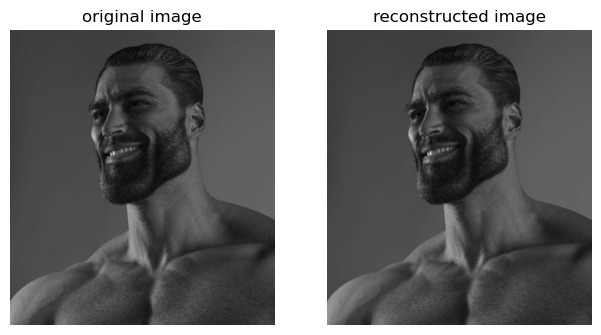

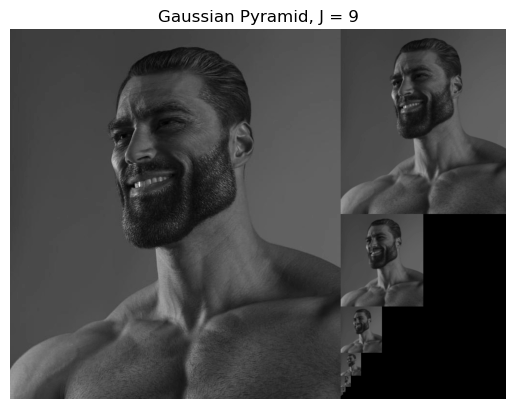

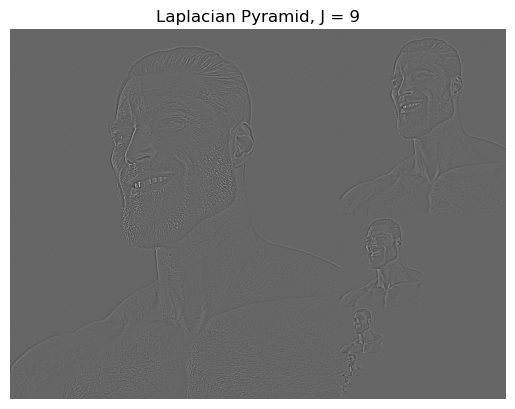

In [4]:
image = cv2.imread('gigachad.jpg', 0)
laplacian, gaussian = laplacian_pyramid(image, 10)
image_reconstruct = reconstruct_laplacian(laplacian)

fig, axs = plt.subplots(1, 2, figsize=(7.5,10))
images = [image, image_reconstruct]
titles = ['original image', 'reconstructed image']
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

display_pyramid(gaussian, "Gaussian");
display_pyramid(laplacian, "Laplacian");

<a id='p1c'></a>
### (c)
Write a function `quantize_pyramid` that takes in a Laplacian pyramid and quantizes the coefficients $c$ with quantization step-size *q* as follows,

\begin{aligned}Q(c,q) = q\left\lfloor\frac{c-\mu}{q}+\frac{1}{2}\right\rfloor+\mu\end{aligned}

where $\mu$ is the mean of the coefficient map, assumed to be $\mu = 0$ for residual (Laplacian) images and $\mu = 128$ otherwise (Gaussian images).

[Table of Contents](#Table-of-Contents)

In [5]:
def quantize_pyramid(pyramid, q):
    quantized_pyramid = []
    mu = 0
    for i in range(len(pyramid)):
        if i == (len(pyramid) - 1):
            mu = 128
        quaantized_coefficients = q * np.floor((pyramid[i] - mu) / q + 1/2) + mu
        quantized_pyramid.append(quaantized_coefficients)#.astype('uint8'))
    return quantized_pyramid

<a id='p1d'></a>
### (d)
For pyramid levels $J = 0, 1, 2, 3$ (where $J = 0$ is simply the original image) plot the reconstruction PSNR,

\begin{aligned}PSNR=10\log _{10}\left(\frac{255^{2}}{MSE}\right)\end{aligned}

between the original and reconstructed image vs. the number of non-zeros in the representation for pyramids quantized at steps $q = 2^{n},\space n=0,1,\dots,8$. Plot PSNR on the y-axis and NNZ on the x-axis.

What relationship do you observe between pyramid depth and representation efficiency for a desired reconstruction PSNR? Is this expected? Such a curve helps us evaluate the representation efficiency of the Laplacian pyramid.

Note that we're using the number of non-zeros (NNZ) as a surrogate for the number of bits needed to describe the image.

[Table of Contents](#Table-of-Contents)

In [6]:
import math
def PSNR(original, reconstruct):
    mse = np.mean((original - reconstruct) ** 2)
    if mse == 0:
        return 100
    return 10 * math.log10(255 ** 2 / mse)

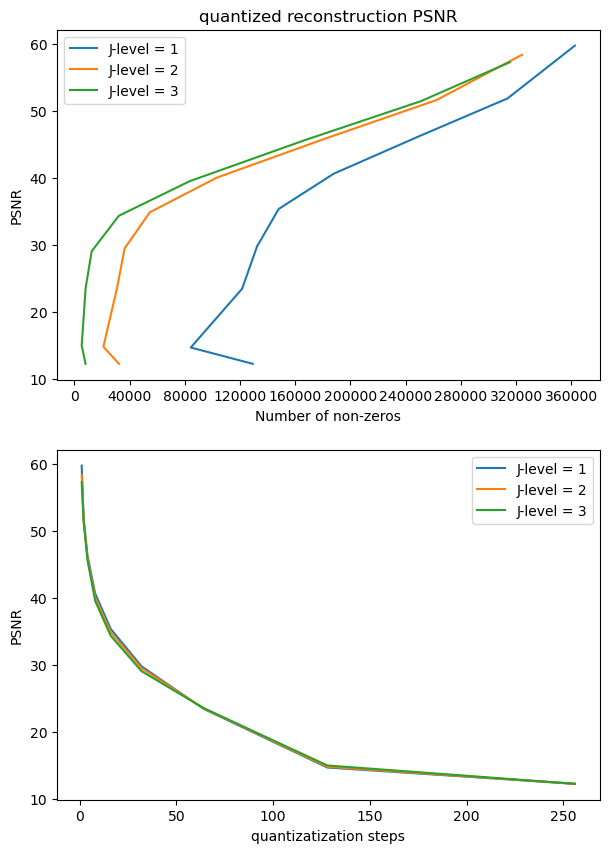

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,10))
for J in range(1,4):
    laplacian, _ = laplacian_pyramid(image, J)
    psnr = []
    nnz = [] 
    for q in [2**n for n in range(9)]:
        quantized_laplacian = quantize_pyramid(laplacian, q)
        nnz.append(sum(np.count_nonzero(ql) for ql in quantized_laplacian))
        psnr.append(PSNR(image, reconstruct_laplacian(quantized_laplacian)))
    ax1.plot(nnz,psnr,label=f"J-level = {J}")
    ax2.plot([2**n for n in range(9)],psnr,label=f"J-level = {J}")
ax1.set_title("quantized reconstruction PSNR")
ax1.set_xlabel("Number of non-zeros"); ax2.set_xlabel("quantizatization steps")
ax1.set_ylabel("PSNR"); ax2.set_ylabel("PSNR")
ax1.set_xticks([40000*nz for nz in range(10)])
ax1.legend(),ax2.legend()
plt.show()

We can see that, the higher the laplacian pyramid depth is, the more efficient the representation of the image is as fewer non-zero values are required to store the image. This is expected as highest level of the laplacian pyramid contains the high frequncy values whereas the the lower levels contain only the edge information. Quantizing allows us to store a more efficient and more sparse representation of the original image.

<a id='p1e'></a>
### (e)
For $J=3$, determine qualitatively at what point the quantization level is unnoticeable. How do the number of non-zeros compare to the original image?

[Table of Contents](#Table-of-Contents)

For $J=3$, we can that the quantization level is relatively unnoticeable until the quantization step is 8 or $q = 2^{3}$. There are 516,795 non-zeros values in the original image which are almost all the pixels in the original image i.e. $760\times680=516,795$. On the otherhand, the quantized image has 166,044 non-zeros.

For the original image, NNZ = 516795


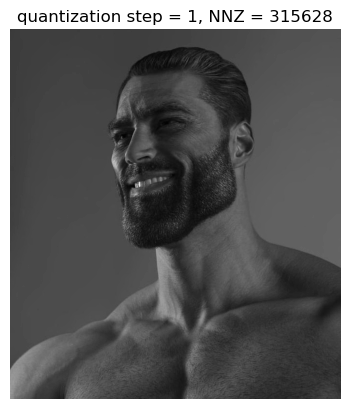

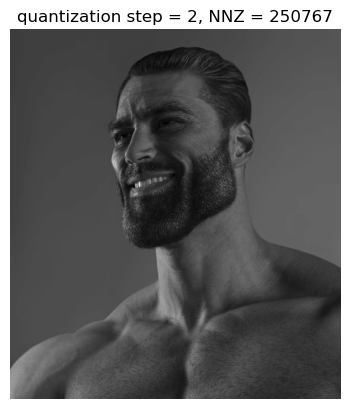

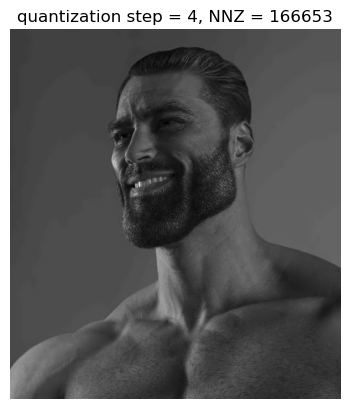

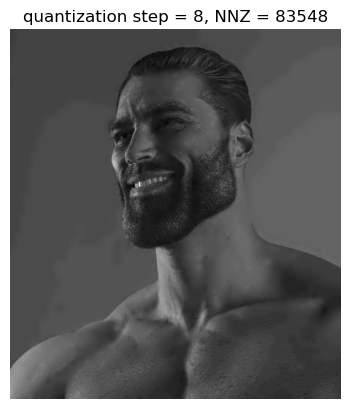

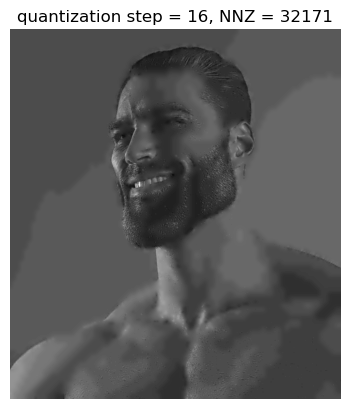

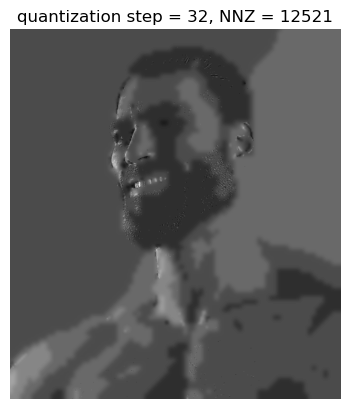

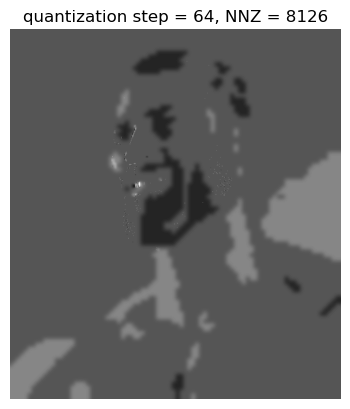

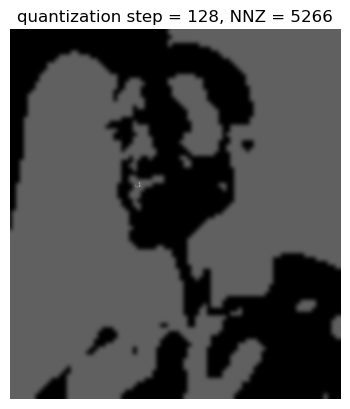

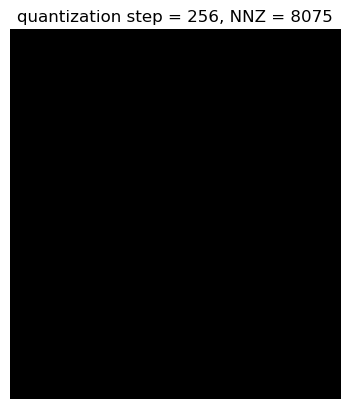

In [8]:
print(f"For the original image, NNZ = {np.count_nonzero(image)}")
laplacian, _ = laplacian_pyramid(image, 3)
for q in [2**n for n in range(9)]:
    plt.figure()
    quantized_laplacian = quantize_pyramid(laplacian, q)
    nnz = sum(np.count_nonzero(ql) for ql in quantized_laplacian)
    plt.imshow(reconstruct_laplacian(quantized_laplacian), cmap='gray')
    plt.axis('off')
    plt.title(f"quantization step = {q}, NNZ = {nnz}")

<a id='p2'></a>

## **Problem 2** (Wavelet Transform).

<a id='p2a'></a>
### (a)
Use PyWavelet's `dwt2` and `idwt2` to write $J$-level wavelet transform (`wavelet_transform`) and reconstruction (`reconstruct_wavelet`) functions, for a grayscale input image. Use symmetric boundary conditions.

[Table of Contents](#Table-of-Contents)

In [9]:
import pywt
def wavelet_transform(image, j_levels, wavelet_family='haar', mode_type='symmetric'):
    wavelet = []
    for j_level in range(j_levels):
        (image, wavelet_j) = pywt.dwt2(image, wavelet_family, mode_type)
        wavelet.append(wavelet_j)
    wavelet.append(image)
    return wavelet

def reconstruct_wavelet(wavelet, wavelet_family='haar', mode_type='symmetric'):
    image = wavelet[-1]
    for j in range(2, len(wavelet)+1):
        image = pywt.idwt2((image, wavelet[-j]), wavelet_family, mode_type)
    return image

<a id='p2b'></a>
### (b)
Repeat parts ([b](#p1b),[c](#p1c),[d](#p1d),[e](#p1e)) from [problem 1](#p1), now with your wavelet transform functions and wavelet subimages.

[Table of Contents](#Table-of-Contents)

Reconstructs the original image from a $J$-level wavelet transform. Verify it works correctly on a test image. Display the waveelet transform images for $J$ = 3.

In [10]:
def display_wavelet(wavelet, title="wavelet transform"):
    rows, cols = wavelet[-1].shape
    composite_rows = rows + sum(w[2].shape[0] for w in wavelet[:-1])
    composite_cols = cols + sum(w[2].shape[1] for w in wavelet[:-1])
    composite_image = np.zeros((composite_rows, composite_cols),
                           dtype=np.double)
    composite_image[:rows, :cols] = normlize_image(wavelet[-1])
    for w in wavelet[-2::-1]:
        n_rows, n_cols = w[2].shape[:2]
        composite_image[:n_rows, cols:cols+n_cols] = normlize_image(w[0])
        composite_image[rows:rows + n_rows, :n_cols] = normlize_image(w[1])
        composite_image[rows:rows + n_rows, cols:cols + n_cols] = normlize_image(w[2])
        rows, cols = rows + n_rows, cols + n_cols
    plt.figure()
    plt.imshow(composite_image, cmap='gray')
    plt.title(f"{title}, J = {len(wavelet)-1}")
    plt.axis('off')
    plt.show()
    return composite_image

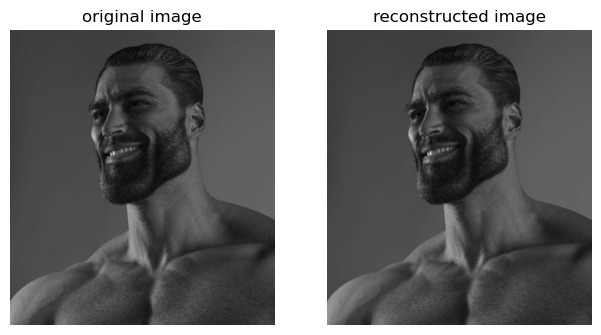

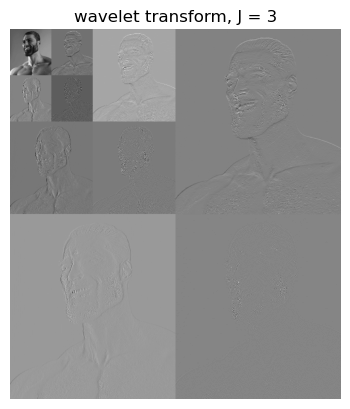

In [11]:
image = cv2.imread("gigachad.jpg", 0)
wavelet = wavelet_transform(image, 3)
image_wavelet = reconstruct_wavelet(wavelet)

fig, axs = plt.subplots(1, 2, figsize=(7.5,8.5))
images = [image, image_wavelet]
titles = ['original image', 'reconstructed image']
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

display_wavelet(wavelet);

Write a function `quantize_wavelet` similar to [Problem 1 (c)](#p1c)

In [12]:
def quantize_wavelet(wavelet, q):
    quantized_wavelet = []
    mu = 0
    for level in wavelet[:-1]:
        quantized_level = []
        for image in level:
            quantized_coefficients = q * np.floor((image - mu) / q + 1/2) + mu
            quantized_level.append(quantized_coefficients)#.astype('uint8'))
        quantized_wavelet.append(quantized_level)
    quantized_wavelet.append(q * np.floor((wavelet[-1] - 128) / q + 1/2) + 128)
    return quantized_wavelet

Repeat [Problem 1 (d)](#p1d)

60.12500000000002 563.8466873065015 1262.1250000000005
0.0 566.0849535603716 1280.0
-32.0 70.76061919504646 288.0000000000001


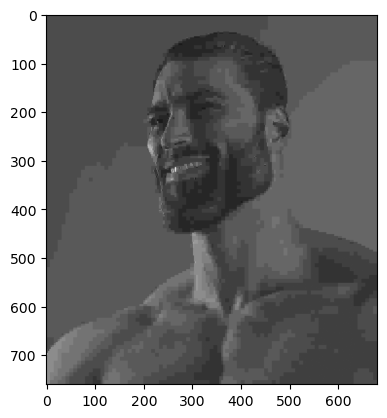

In [13]:
q = quantize_wavelet(wavelet, 128)
r = reconstruct_wavelet(q)

print(wavelet[-1].min(),wavelet[-1].mean(), wavelet[-1].max())
print(q[-1].min(),q[-1].mean(), q[-1].max())
print(r.min(),r.mean(), r.max())
plt.figure();
plt.imshow(r, cmap='gray');

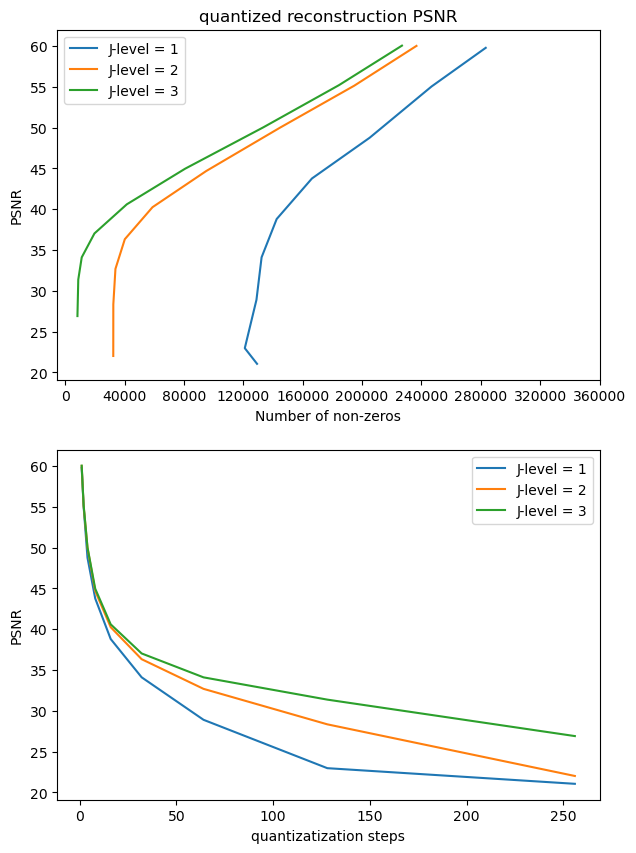

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,10))
for J in range(1,4):
    wavelet = wavelet_transform(image, J)
    psnr = []
    nnz = [] 
    for q in [2**n for n in range(9)]:
        quantized_wavelet = quantize_wavelet(wavelet, q)
        nnz.append(sum(np.count_nonzero(qw) for qw in quantized_wavelet))
        psnr.append(PSNR(image, reconstruct_wavelet(quantized_wavelet)))
    ax1.plot(nnz,psnr,label=f"J-level = {J}")
    ax2.plot([2**n for n in range(9)],psnr,label=f"J-level = {J}")
ax1.set_title("quantized reconstruction PSNR")
ax1.set_xlabel("Number of non-zeros"); ax2.set_xlabel("quantizatization steps")
ax1.set_ylabel("PSNR"); ax2.set_ylabel("PSNR")
ax1.set_xticks([40000*nz for nz in range(10)])
ax1.legend(),ax2.legend()
plt.show()

We can see that, the higher the wavelet transform depth is, the more efficient the representation of the image is as fewer non-zero values are required to store the image. This is expected as highest level of the wavelet transform contains the high frequncy values whereas the the lower levels contain only the edge information. Quantizing allows us to store a more efficient and more sparse representation of the original image.

Repeat [Problem 1 (e)](#p1e)

For $J=3$, we can that the quantization level is relatively unnoticeable until the quantization step is 16 or $q = 2^{4}$. There are 516,795 non-zeros values in the original image which are almost all the pixels in the original image i.e. $760\times680=516,795$. On the otherhand, the quantized image only has 80,747 non-zeros.

For the original image, NNZ = 516795


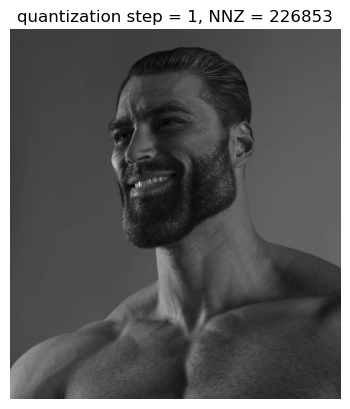

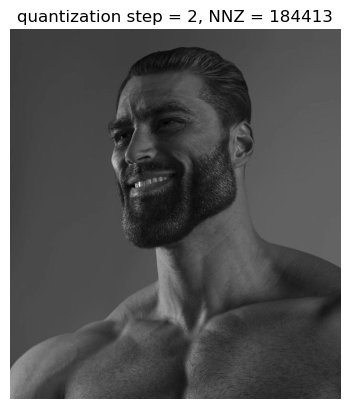

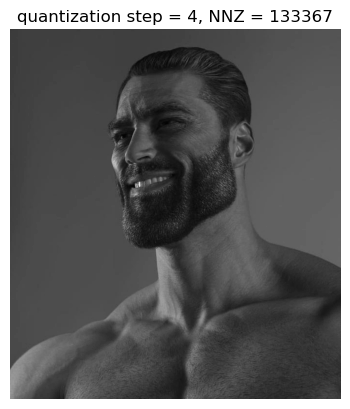

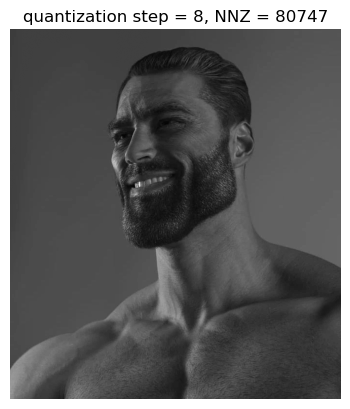

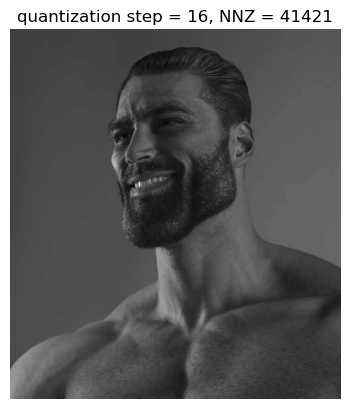

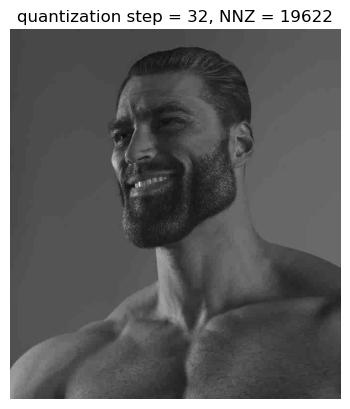

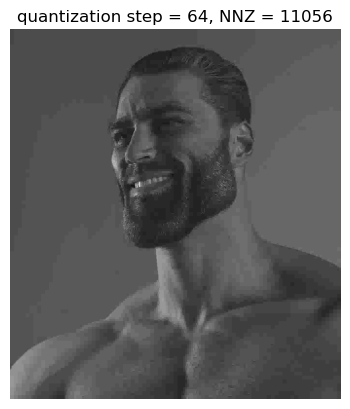

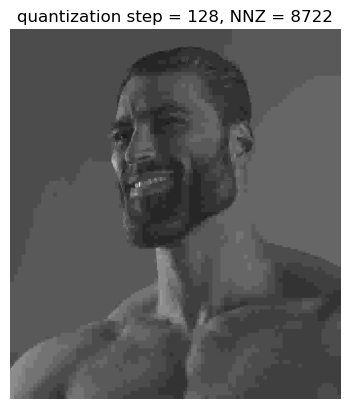

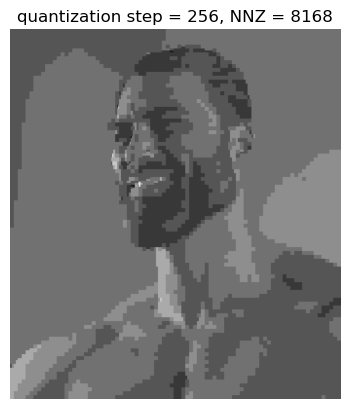

In [15]:
print(f"For the original image, NNZ = {np.count_nonzero(image)}")
wavelet = wavelet_transform(image, 3)
for q in [2**n for n in range(9)]:
    plt.figure()
    quantized_wavelet = quantize_wavelet(wavelet, q)
    nnz = sum(np.count_nonzero(qw) for qw in quantized_wavelet)
    plt.imshow(reconstruct_wavelet(quantized_wavelet), cmap='gray')
    plt.axis('off')
    plt.title(f"quantization step = {q}, NNZ = {nnz}")

<a id='p2c'></a>
### (c)
Based on your results, compare the representation efficiency of the Laplacian pyramid and wavelet transform in terms of the NNZ required to represent an image to the same quality (PSNR).

The wavelet transform is able to store an image with fewer number of non-zeros for the same quantization level. Visually, images reconstructed using wavelet transform are also better looking with less noticable artifacts as compared to the the images compared with laplacian transform. Wavelet transform also has a higher PSNR for a specific NNZ. indicating a better reconstruction.

[Table of Contents](#Table-of-Contents)